In [23]:
import cv2, os
from PIL import Image

In [24]:
data_path='dataset' #set the path of the data set

categories=os.listdir(data_path) # makes a list of categories(directories) in dataset

labels=[i for i in range(len(categories))] # makes a list of directories and number them 

label_dict=dict(zip(categories,labels)) #create a dictionary

print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [25]:
img_size = 100
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category) #joins the path o dataset with the categories of data
    img_names = os.listdir(folder_path) #adding the name of the images to a list

    for img_name in img_names:
        img_path = os.path.join(folder_path,img_name) #path of each image
        img=cv2.imread(img_path) #adding the images to a list img

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #converting images to gray scale
            resized=cv2.resize(gray,(img_size,img_size)) #converting the images to 100*100
            data.append(resized) #appending the images to data array
            target.append(label_dict[category]) #appending the label(categories) 

        except Exception as e:
            print('Exception: ',e)
            #if any exception rise

In [26]:
from keras.utils import np_utils
import numpy as np

data = np.array(data)/255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)


new_target = np_utils.to_categorical(target)


In [27]:
np.save('data', data)
np.save('target', new_target)

In [28]:
data = np.load('data.npy')
target = np.load('target.npy')

#loading the save numpy arrays in the previous code

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv2D(200, (3, 3), input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50, activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2, activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


In [30]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.1)


In [31]:
checkpoint = ModelCheckpoint(
    'model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = model.fit(train_data, train_target, epochs=20,
                    callbacks=[checkpoint], validation_split=0.2)


Epoch 1/20
31/31 [==============================] - 34s 1s/step - loss: 0.7150 - accuracy: 0.5728 - val_loss: 0.5677 - val_accuracy: 0.7298
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/20
31/31 [==============================] - 33s 1s/step - loss: 0.5659 - accuracy: 0.7029 - val_loss: 0.3379 - val_accuracy: 0.8710
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/20
31/31 [==============================] - 41s 1s/step - loss: 0.3175 - accuracy: 0.8708 - val_loss: 0.2452 - val_accuracy: 0.9274
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/20
31/31 [==============================] - 40s 1s/step - loss: 0.1961 - accuracy: 0.9282 - val_loss: 0.2645 - val_accuracy: 0.9153
Epoch 5/20
31/31 [==============================] - 41s 1s/step - loss: 0.2007 - accuracy: 0.9298 - val_loss: 0.1969 - val_accuracy: 0.9395
INFO:tensorflow:Assets written to: model-005.model\assets
Epoch 6/20
31/31 [==============================] - 35s 1s/step - lo

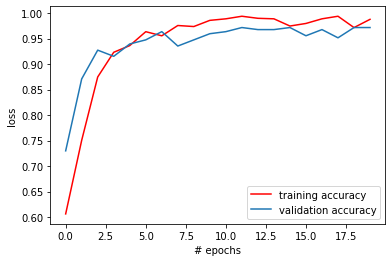

In [33]:
plt.plot(history.history['accuracy'], 'r', label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [34]:
print(model.evaluate(test_data, test_target))


5/5 [==============================] - 1s 211ms/step - loss: 0.1771 - accuracy: 0.9638
[0.17706987261772156, 0.9637681245803833]


In [35]:
from keras.models import load_model
import cv2
import numpy as np

In [38]:
model = load_model('model-010.model')

face_clsfr = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source = cv2.VideoCapture(0)

labels_dict = {0: 'MASK', 1: 'NO MASK'}
color_dict = {0: (0, 255, 0), 1: (0, 0, 255)}


In [39]:
while(True):
    ret, img = source.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print(img) or print(img.shape)
    faces = face_clsfr.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:

        face_img = gray[y:y+w, x:x+w]
        resized = cv2.resize(face_img, (100, 100))
        normalized = resized/255.0
        reshaped = np.reshape(normalized, (1, 100, 100, 1))
        result = model.predict(reshaped)

        label = np.argmax(result, axis=1)[0]

        cv2.rectangle(img, (x, y), (x+w, y+h), color_dict[label], 2)
        cv2.rectangle(img, (x, y-40), (x+w, y), color_dict[label], -1)
        cv2.putText(img, labels_dict[label], (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    cv2.imshow('LIVE', img)
    key = cv2.waitKey(1)

    if(key == 27):
        break

cv2.destroyAllWindows()
source.release()


[[[ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]
  ...
  [ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]]

 [[ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]
  ...
  [ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]]

 [[ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]
  ...
  [ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]]

 ...

 [[ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]
  ...
  [ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]]

 [[ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]
  ...
  [ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]]

 [[ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]
  ...
  [ 36 137 255]
  [ 36 137 255]
  [ 36 137 255]]]
(480, 640, 3)
[[[106 100  95]
  [106 100  95]
  [105  99  92]
  ...
  [109 109 103]
  [110 110 104]
  [110 110 104]]

 [[109 103  98]
  [109 103  98]
  [108 102  95]
  ...
  [108 108 102]
  [108 108 102]
  [109 109 103]]

 [[107 101  96]
  [106 100  95]
  [107  99  92]
  ...
  [107 107 101]
  [107 107 101]
  [107 107 101]]

 ...

 [[ 71  76  79]
  [ 71  76  79]
  [ 69